In [1]:
import functools
import glob
import os

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
from scipy import stats

In [3]:
import lib

In [4]:
def watermark(
    fig,
    text="preliminary",
):
    fig_width, fig_height = fig.get_size_inches()
    angle = np.degrees(np.arctan2(fig_height, fig_width))
    size = np.hypot(fig_width, fig_height) * 6 
    fig.text(
        0.5,
        0.5,
        text,
        color="k",
        alpha=0.1,
        fontsize=size,
        rotation=angle,
        horizontalalignment="center",
        verticalalignment="center",
    )

    return None

In [5]:
os.environ["IMSIM_DATA"] = "/global/cfs/cdirs/desbalro"

In [6]:
shear_step_plus = 'g1_slice=0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0'
shear_step_minus = 'g1_slice=-0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0'

In [7]:
shear_step = shear_step_minus

In [8]:
# hf_imsim = h5py.File(lib.const.IMSIM_CATALOGS[shear_step])
# hf_redshift = h5py.File(lib.const.REDSHIFT_CATALOGS[shear_step])
# hf_match = h5py.File(lib.const.MATCH_CATALOGS[shear_step])

---

In [13]:
MDET_SHEAR_CATALOG = "/global/cfs/projectdirs/des/y6-shear-catalogs/Y6A2_METADETECT_V6_UNBLINDED/metadetect_cutsv6_all.h5"

In [14]:
MDET_REDSHIFT_CATALOG = "/global/cfs/cdirs/des/y6-redshift/sompz_v6_10000Tile_final_unblind_24-11-05.h5"

In [9]:
imsim_base = "/global/cfs/cdirs/des/y6-image-sims/fiducial-400/"
imsim_catalogs = {
    shear_step: os.path.join(
        imsim_base,
        shear_step,
        "metadetect_cutsv6_all.h5",
    )
    for shear_step in lib.const.SHEAR_STEPS
}

redshift_base = "/global/cfs/cdirs/des/y6-redshift/imsim_400Tile/fidbin_S005/"
redshift_catalogs = {
    shear_step: os.path.join(
        redshift_base,
        f"{shear_step}_sompz_unblind_fidbin.h5"
    )
    for shear_step in lib.const.SHEAR_STEPS
}

In [17]:
hf_shear_y6 = h5py.File(MDET_SHEAR_CATALOG)
hf_redshift_y6 = h5py.File(MDET_REDSHIFT_CATALOG)

In [18]:
bhat_y6 = lib.tomography.get_tomography(
    hf_shear_y6,
    hf_redshift_y6,
    "noshear",
)

In [19]:
assignments_y6 = {
    mdet_step: lib.tomography.get_assignment(
        hf_shear_y6,
        hf_redshift_y6,
        mdet_step,
    )
    for mdet_step in lib.const.MDET_STEPS
}

In [20]:
statistical_weights_y6 = {
    mdet_step: lib.weights.get_shear_weights(
        hf_shear_y6["mdet"][mdet_step],
    )
    for mdet_step in lib.const.MDET_STEPS
}

In [26]:
_count_y6, _, _ = stats.binned_statistic(
    assignments_y6["noshear"],
    None,
    statistic="count",
    bins=lib.const.CELL_IDS,
)

count_grid_y6 = _count_y6

---

In [21]:
hf_shear_sim = h5py.File(imsim_catalogs[shear_step])
hf_redshift_sim = h5py.File(redshift_catalogs[shear_step])
# hf_match = h5py.File(lib.const.MATCH_CATALOGS[shear_step])

In [22]:
bhat_sim = lib.tomography.get_tomography(
    hf_shear_sim,
    hf_redshift_sim,
    "noshear",
)

In [23]:
assignments_sim = {
    mdet_step: lib.tomography.get_assignment(
        hf_shear_sim,
        hf_redshift_sim,
        mdet_step,
    )
    for mdet_step in lib.const.MDET_STEPS
}

In [24]:
statistical_weights_sim = {
    mdet_step: lib.weights.get_shear_weights(
        hf_shear_sim["mdet"][mdet_step],
    )
    for mdet_step in lib.const.MDET_STEPS
}

In [27]:
_count_sim, _, _ = stats.binned_statistic(
    assignments_sim["noshear"],
    None,
    statistic="count",
    bins=lib.const.CELL_IDS,
)

count_grid_sim = _count_sim

---

In [56]:
occupancy_grid_y6 = count_grid_y6 / sum(count_grid_y6)

In [57]:
occupancy_grid_sim = count_grid_sim / sum(count_grid_sim)

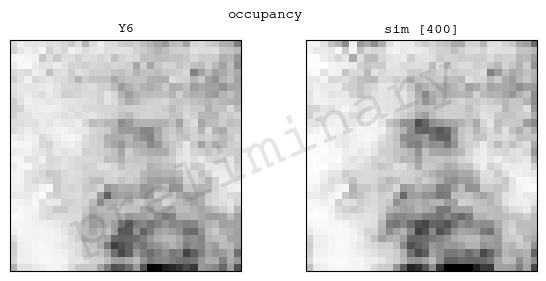

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))

norm = mpl.colors.Normalize(vmin=0)

axs[0].imshow(
    occupancy_grid_y6.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=norm,
)
axs[0].set_title("Y6")

axs[1].imshow(
    occupancy_grid_sim.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=norm,
)
axs[1].set_title("sim [400]")

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle("occupancy")

watermark(fig)

plt.show()

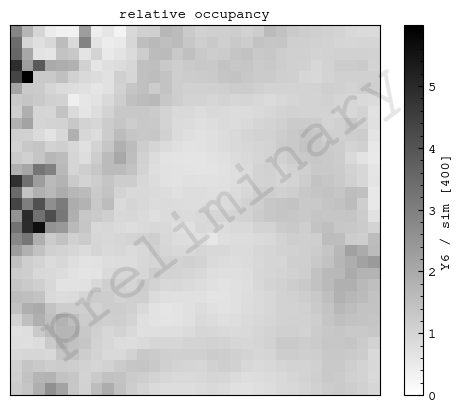

In [63]:
fig, axs = plt.subplots(1, 1)

im = axs.imshow(
    (occupancy_grid_y6 / fraction_grid_sim).reshape(lib.const.SOM_SHAPE),
    origin="lower",
    vmin=0,
)
axs.set_title("relative occupancy")

fig.colorbar(im, ax=axs, label="Y6 / sim [400]")

axs.set_xticks([])
axs.set_yticks([])

watermark(fig)

plt.show()

---

In [51]:
weight_grid_y6, _, _ = stats.binned_statistic(
    assignments_y6["noshear"],
    statistical_weights_y6["noshear"],
    statistic="sum",
    bins=lib.const.CELL_IDS,
)

In [52]:
weight_grid_sim, _, _ = stats.binned_statistic(
    assignments_sim["noshear"],
    statistical_weights_sim["noshear"],
    statistic="sum",
    bins=lib.const.CELL_IDS,
)

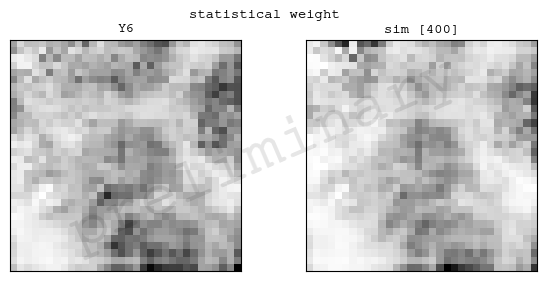

In [62]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))

# norm = mpl.colors.Normalize(vmin=0)

axs[0].imshow(
    weight_grid_y6.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    # norm=norm,
)
axs[0].set_title("Y6")

axs[1].imshow(
    weight_grid_sim.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    # norm=norm,
)
axs[1].set_title("sim [400]")


for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle("statistical weight")

watermark(fig)

plt.show()

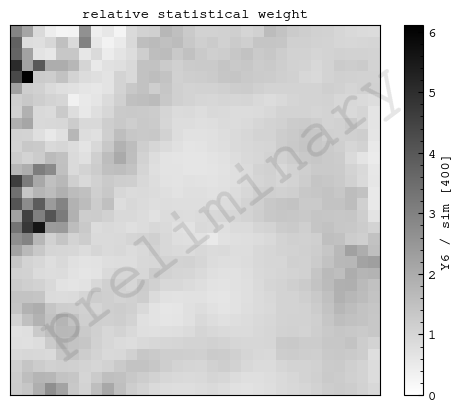

In [65]:
fig, axs = plt.subplots(1, 1)

im = axs.imshow(
    (weight_grid_y6 / sum(weight_grid_y6) / (weight_grid_sim / sum(weight_grid_sim))).reshape(lib.const.SOM_SHAPE),
    origin="lower",
    vmin=0,
)
axs.set_title("relative statistical weight")

fig.colorbar(im, ax=axs, label="Y6 / sim [400]")

axs.set_xticks([])
axs.set_yticks([])

watermark(fig)

plt.show()

---

In [66]:
g1_y6 = {
    mdet_step: hf_shear_y6["mdet"][mdet_step]["gauss_g_1"][:]
    for mdet_step in lib.const.MDET_STEPS
}

g2_y6 = {
    mdet_step: hf_shear_y6["mdet"][mdet_step]["gauss_g_2"][:]
    for mdet_step in lib.const.MDET_STEPS
}

In [67]:
# response grid
mean_g1_y6 = {}
mean_g2_y6 = {}
for mdet_step in ["1p", "1m"]:
    _sum_weight, _, _ = stats.binned_statistic(
        assignments_y6[mdet_step],
        statistical_weights_y6[mdet_step],
        statistic="sum",
        bins=lib.const.CELL_IDS,
    )

    _sum_g1, _, _ = stats.binned_statistic(
        assignments_y6[mdet_step],
        statistical_weights_y6[mdet_step] * g1_y6[mdet_step],
        statistic="sum",
        bins=lib.const.CELL_IDS,
    )
    mean_g1_y6[mdet_step] = _sum_g1 / _sum_weight

    _sum_g2, _, _ = stats.binned_statistic(
        assignments_y6[mdet_step],
        statistical_weights_y6[mdet_step] * g2_y6[mdet_step],
        statistic="sum",
        bins=lib.const.CELL_IDS,
    )
    mean_g2_y6[mdet_step] = _sum_g2 / _sum_weight

response_grid_y6 = (mean_g1_y6["1p"] - mean_g1_y6["1m"]) / (2 * 0.01)

In [70]:
del g1_y6, g2_y6

In [68]:
g1_sim = {
    mdet_step: hf_shear_sim["mdet"][mdet_step]["gauss_g_1"][:]
    for mdet_step in lib.const.MDET_STEPS
}

g2_sim = {
    mdet_step: hf_shear_sim["mdet"][mdet_step]["gauss_g_2"][:]
    for mdet_step in lib.const.MDET_STEPS
}

In [69]:
# response grid
mean_g1_sim = {}
mean_g2_sim = {}
for mdet_step in ["1p", "1m"]:
    _sum_weight, _, _ = stats.binned_statistic(
        assignments_sim[mdet_step],
        statistical_weights_sim[mdet_step],
        statistic="sum",
        bins=lib.const.CELL_IDS,
    )

    _sum_g1, _, _ = stats.binned_statistic(
        assignments_sim[mdet_step],
        statistical_weights_sim[mdet_step] * g1_sim[mdet_step],
        statistic="sum",
        bins=lib.const.CELL_IDS,
    )
    mean_g1_sim[mdet_step] = _sum_g1 / _sum_weight

    _sum_g2, _, _ = stats.binned_statistic(
        assignments_sim[mdet_step],
        statistical_weights_sim[mdet_step] * g2_sim[mdet_step],
        statistic="sum",
        bins=lib.const.CELL_IDS,
    )
    mean_g2_sim[mdet_step] = _sum_g2 / _sum_weight

response_grid_sim = (mean_g1_sim["1p"] - mean_g1_sim["1m"]) / (2 * 0.01)

In [71]:
del g1_sim, g2_sim

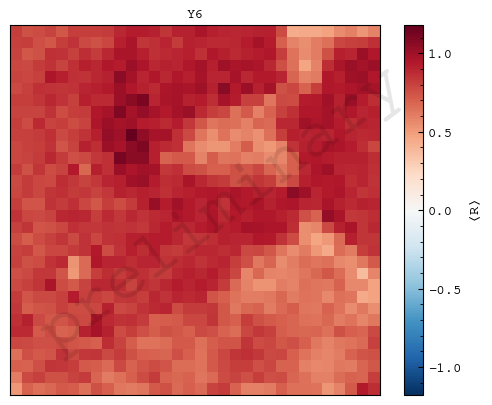

In [79]:
fig, axs = plt.subplots(1, 1)

norm=mpl.colors.CenteredNorm()

m = axs.imshow(
    response_grid_y6.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    cmap="RdBu_r",
    norm=norm,
)
fig.colorbar(m, label="$〈R〉$")

axs.set_xticks([])
axs.set_yticks([])
axs.set_title("Y6")

watermark(fig)

plt.show()

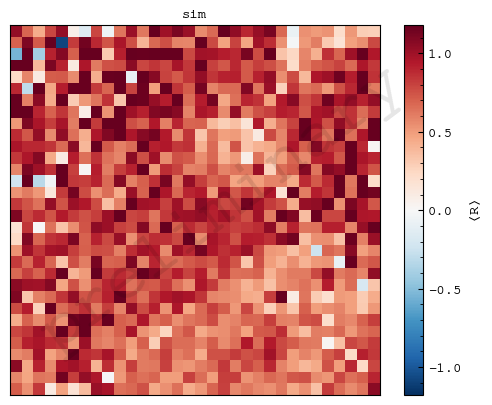

In [80]:
fig, axs = plt.subplots(1, 1)

m = axs.imshow(
    response_grid_sim.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    cmap="RdBu_r",
    norm=norm,  # reuse norm from y6
)
fig.colorbar(m, label="$〈R〉$")

axs.set_xticks([])
axs.set_yticks([])
axs.set_title("sim")

watermark(fig)

plt.show()

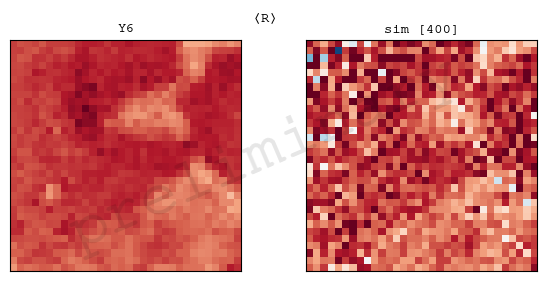

In [75]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))

# norm = mpl.colors.Normalize(vmin=0)
norm=mpl.colors.CenteredNorm()

axs[0].imshow(
    response_grid_y6.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    cmap="RdBu_r",
    norm=norm,
)
axs[0].set_title("Y6")

axs[1].imshow(
    response_grid_sim.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    cmap="RdBu_r",
    norm=norm,
)
axs[1].set_title("sim [400]")

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle("$〈R〉$")

watermark(fig)

plt.show()

---

In [12]:
zbinsc = hf_redshift["sompz"]["pzdata_weighted_S005"]["zbinsc"][:]

zc = np.concatenate([[0.0], zbinsc])

nz_sompz = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    _nz_p = hf_redshift["sompz"]["pzdata_weighted_S005"][f"bin{tomographic_bin}"][:]
    _nz_p = np.concatenate([[0.0], _nz_p])
    
    _nz_p = _nz_p / np.asarray(lib.util.sompz_integral(_nz_p, zc, 0, 6.0))
    
    
    _nz_m = hf_redshift["sompz"]["pzdata_weighted_S005"][f"bin{tomographic_bin}"][:]
    _nz_m = np.concatenate([[0.0], _nz_m])
    
    _nz_m = _nz_m / np.asarray(lib.util.sompz_integral(_nz_m, zc, 0, 6.0))

    
    nz_sompz[tomographic_bin] = (_nz_p + _nz_m) / 2 
    
nz_sompz[-1] = (nz_sompz[0] + nz_sompz[1] + nz_sompz[2] + nz_sompz[3]) / 4

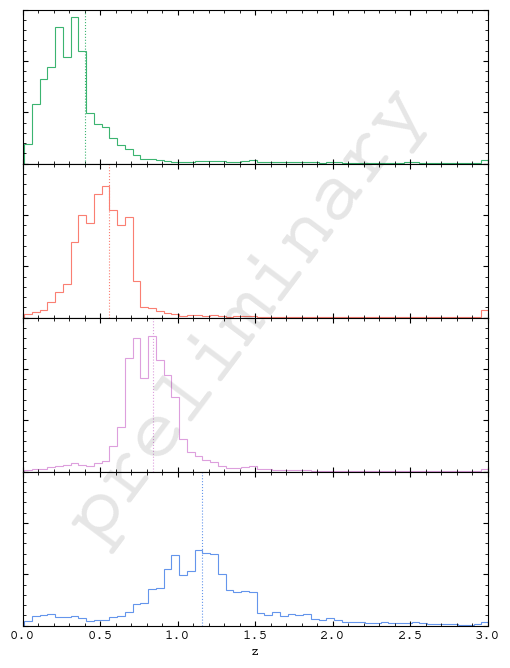

In [32]:
fig, axs = plt.subplots(len(lib.const.TOMOGRAPHIC_BINS), 1, figsize=(6, 8), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

TOMO_COLORS = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

for i in lib.const.TOMOGRAPHIC_BINS:
    axs[i].axvline(
        np.average(lib.const.ZVALS, weights=nz_sompz[i]),
        c=TOMO_COLORS[i],
        ls=":",
    )
    
    axs[i].stairs(
        nz_sompz[i],
        edges=lib.const.ZEDGES,
        ec=TOMO_COLORS[i],
    )

axs[-1].set_xlim(0, 3)
axs[-1].set_ylim(0, None)

axs[-1].set_xlabel("z")
axs[-1].set_yticklabels([])

# axs[-1].set_yscale("log")
# axs[0].legend()

watermark(fig)

plt.show()

---

In [27]:
# _, _, _, = np.intersect1d(
#     hf_imsim["mdet"]["noshear"]["uid"],
#     hf_match["mdet"]["noshear"]["uid"],
#     return_indices=True,
# )

In [28]:
# one non-unique id -- np.nan
np.sort(
    np.unique(
        hf_match["mdet"]["noshear"]["uid"],
        return_counts=True,
    ),
    axis=1,
)

array([[4.89800000e+03, 4.90100000e+03, 4.90200000e+03, ...,
        1.29023546e+09, 1.29023564e+09,            nan],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.09117000e+05]])

In [29]:
match_indices = ~np.isnan(hf_match["mdet"]["noshear"]["uid"])

In [30]:
100 * len(match_indices) / hf_match["mdet"]["noshear"]["uid"].len()

100.0

In [31]:
sum(~np.isnan(assignments["noshear"]))

51475

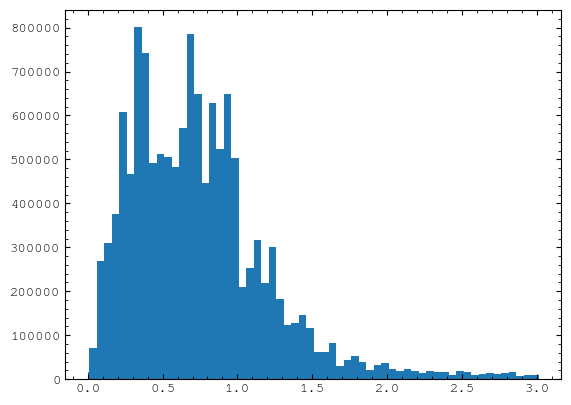

In [32]:
plt.hist(
    hf_match["mdet"]["noshear"]["z"][match_indices],
    bins=lib.const.ZEDGES,
)
plt.show()

In [33]:
# extend the last bin and "pileup"
zedges = np.copy(lib.const.ZEDGES)
zedges[-1] = 4.

_sum_weight, _, _, _ = stats.binned_statistic_2d(
    assignments["noshear"][match_indices],
    hf_match["mdet"]["noshear"]["z"][match_indices],
    statistical_weights["noshear"][match_indices],
    statistic="sum",
    bins=[lib.const.CELL_IDS, zedges],
)

nz = _sum_weight / np.diff(lib.const.ZEDGES)
# nz /= nz.sum()

/tmp/ipykernel_436938/999526811.py:5: RuntimeWarning: invalid value encountered in divide
  np.sum(lib.const.ZVALS * nz, axis=1)


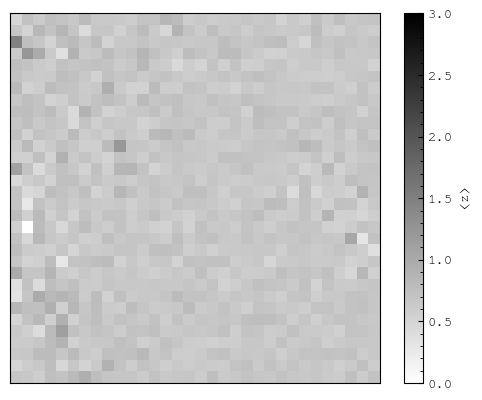

In [34]:
fig, axs = plt.subplots(1, 1)

m = axs.imshow(
    (
        np.sum(lib.const.ZVALS * nz, axis=1) 
        / np.sum(nz, axis=1)
    ).reshape(lib.const.SOM_SHAPE),
    origin="lower",
    vmin=0,
    vmax=3,
)
fig.colorbar(m, label="$\\langle z \\rangle$")

axs.set_xticks([])
axs.set_yticks([])

plt.show()

In [35]:
cell_assignments = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    cell_assignments[tomographic_bin] = np.unique(
        assignments["noshear"][bhat == tomographic_bin]
    ).astype(int)

assert len(
    functools.reduce(
        np.intersect1d,
        [
            cells
            for cells in cell_assignments.values()
        ],
    )
) == 0

nz_tomo = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    nz_tomo[tomographic_bin] = np.sum(
        nz[cell_assignments[tomographic_bin]] \
        * response_grid[cell_assignments[tomographic_bin], np.newaxis] \
        * weight_grid[cell_assignments[tomographic_bin], np.newaxis],
        axis=0
    ) / np.sum(
        response_grid[cell_assignments[tomographic_bin]] \
        * weight_grid[cell_assignments[tomographic_bin]]
    )
    # manually force n(0) = 0
    nz_tomo[tomographic_bin][0] = 0


/tmp/ipykernel_436938/2453250930.py:20: RuntimeWarning: invalid value encountered in divide
  np.sum(lib.const.ZVALS * _nz, axis=1)


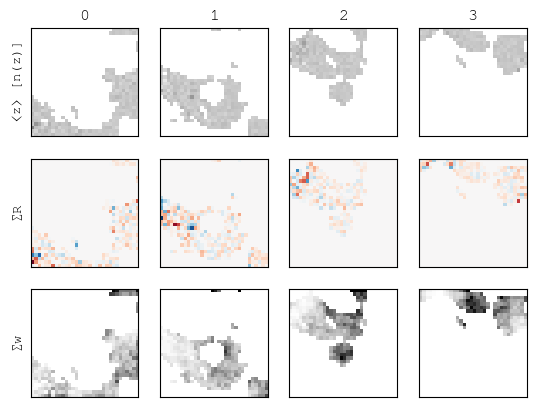

In [36]:
fig, axs = plt.subplots(3, len(lib.const.TOMOGRAPHIC_BINS), sharex=True, sharey=True)

nz_norm = mpl.colors.Normalize(vmin=0, vmax=3)
r_norm = mpl.colors.CenteredNorm()
w_norm = mpl.colors.Normalize(vmin=0)

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    _nz = np.zeros_like(nz)
    _r = np.zeros_like(nz)
    _w = np.zeros_like(nz)
    
    _nz[cell_assignments[tomographic_bin]] = nz[cell_assignments[tomographic_bin]]
    _r[cell_assignments[tomographic_bin]] = response_grid[cell_assignments[tomographic_bin], np.newaxis]
    _w[cell_assignments[tomographic_bin]] = weight_grid[cell_assignments[tomographic_bin], np.newaxis]
    
    axs[0, tomographic_bin].set_title(tomographic_bin)
        
    axs[0, tomographic_bin].imshow(
    (
        np.sum(lib.const.ZVALS * _nz, axis=1) 
        / np.sum(_nz, axis=1)
    ).reshape(lib.const.SOM_SHAPE),
        norm=nz_norm,
    )
    
    axs[1, tomographic_bin].imshow(
        np.sum(_r, axis=1).reshape(lib.const.SOM_SHAPE),
        norm=r_norm,
        cmap="RdBu_r",
    )
    
    axs[2, tomographic_bin].imshow(
        np.sum(_w, axis=1).reshape(lib.const.SOM_SHAPE),
        norm=w_norm,
    )

axs[0, 0].set_ylabel("$\\langle z \\rangle$ [$n(z)$]")
axs[1, 0].set_ylabel("$\\sum R$")
axs[2, 0].set_ylabel("$\\sum w$")

for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

/tmp/ipykernel_436938/2448599643.py:19: RuntimeWarning: invalid value encountered in divide
  np.sum(lib.const.ZVALS * _nz * _r * _w, axis=1)


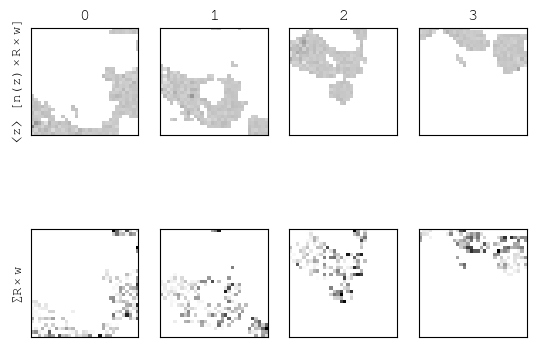

In [37]:
fig, axs = plt.subplots(2, len(lib.const.TOMOGRAPHIC_BINS), sharex=True, sharey=True)

nz_norm = mpl.colors.Normalize(vmin=0, vmax=3)
r_norm = mpl.colors.Normalize(vmin=0)

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    _nz = np.zeros_like(nz)
    _r = np.zeros_like(nz)
    _w = np.zeros_like(nz)
    
    _nz[cell_assignments[tomographic_bin]] = nz[cell_assignments[tomographic_bin]]
    _r[cell_assignments[tomographic_bin]] = response_grid[cell_assignments[tomographic_bin], np.newaxis]
    _w[cell_assignments[tomographic_bin]] = weight_grid[cell_assignments[tomographic_bin], np.newaxis]
    
    axs[0, tomographic_bin].set_title(tomographic_bin)
        
    axs[0, tomographic_bin].imshow(
    (
        np.sum(lib.const.ZVALS * _nz * _r * _w, axis=1) 
        / np.sum(_nz * _r * _w, axis=1)
    ).reshape(lib.const.SOM_SHAPE),
        norm=nz_norm,
    )
    
    axs[1, tomographic_bin].imshow(
        np.sum(_r * _w, axis=1).reshape(lib.const.SOM_SHAPE),
        norm=r_norm,
    )


axs[0, 0].set_ylabel("$\\langle z \\rangle$ [$n(z) \\times R \\times w$]")
axs[1, 0].set_ylabel("$\\sum R \\times w$")


for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

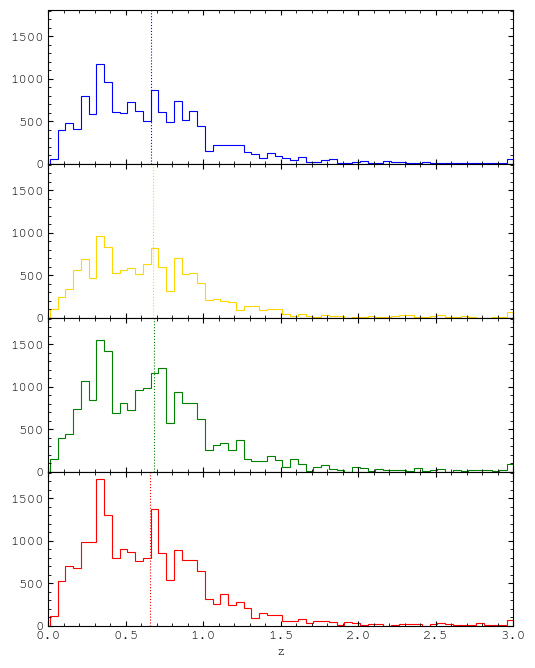

In [38]:
fig, axs = plt.subplots(len(lib.const.TOMOGRAPHIC_BINS), 1, figsize=(6, 8), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

TOMO_COLORS = {
    0: "blue",
    1: "gold",
    2: "green",
    3: "red",
}

for i in lib.const.TOMOGRAPHIC_BINS:
    axs[i].axvline(
        np.average(lib.const.ZVALS, weights=nz_tomo[i]),
        c=TOMO_COLORS[i],
        ls=":",
    )
    
    axs[i].stairs(
        nz_tomo[i],
        edges=lib.const.ZEDGES,
        ec=TOMO_COLORS[i],
    )

axs[-1].set_xlim(0, 3)
axs[-1].set_ylim(0, None)

axs[-1].set_xlabel("z")

# axs[-1].set_yscale("log")
# axs[0].legend()

plt.show()